In [1]:
import pandas as pd
from nba_api.stats.endpoints import playercareerstats
from nba_api.live.nba.endpoints import scoreboard
from nba_api.stats.endpoints import teamdashboardbylastngames
from nba_api.stats.endpoints import teamdashboardbygeneralsplits
from nba_api.stats.endpoints import teamdashboardbyyearoveryear
from nba_api.stats.endpoints import teamgamelogs

In [2]:
seasons = [
    '2009-10',
    '2010-11',
    '2011-12',
    '2012-13',
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2019-20',
    '2020-21',
    '2021-22',
    '2022-23',
]

In [3]:
# Loop through all seasons and collect gamelogs
okc_gamelogs = []
for year in seasons:
    temp_df = teamgamelogs.TeamGameLogs(
                team_id_nullable=1610612760, 
                season_nullable=year,
                measure_type_player_game_logs_nullable='Advanced',
                per_mode_simple_nullable='Per48',
                ).get_data_frames()[0]
    temp_df.sort_values(by='GAME_DATE', inplace=True)
    temp_df['GAME_DATE'] = pd.to_datetime(temp_df['GAME_DATE'])
    temp_df['GAME_DATE'] = temp_df['GAME_DATE'].dt.strftime('%Y-%m-%d')
    temp_df = temp_df[['TEAM_ID','TEAM_ABBREVIATION','GAME_ID','GAME_DATE','MATCHUP','E_OFF_RATING','E_PACE']]
    okc_gamelogs.append(temp_df)

# Combine list of dataframes into one dataframe
okc_gamelogs = pd.concat(okc_gamelogs)
okc_gamelogs.columns = ['team_id','team_abbr','game_id','game_date','matchup','e_off_rtg','e_pace']

In [5]:
# Collect points scored and against for each game
okc_scores = []
for year in seasons:
    temp_df = teamgamelogs.TeamGameLogs(
                team_id_nullable=1610612760, 
                season_nullable=year,
                per_mode_simple_nullable='Per48',
                ).get_data_frames()[0]
    temp_df.sort_values(by='GAME_DATE', inplace=True)
    temp_df['PTS'] = temp_df['PTS'].astype(int)
    temp_df['PTS_AGAINST'] = temp_df['PTS'] - temp_df['PLUS_MINUS']
    temp_df['PTS_AGAINST'] = temp_df['PTS_AGAINST'].astype(int)
    temp_df = temp_df[['TEAM_ID','GAME_ID','PTS','PTS_AGAINST']]
    okc_scores.append(temp_df)

# Combine list of dataframes into one dataframe
okc_scores = pd.concat(okc_scores)
okc_scores.columns = ['team_id','game_id','pts','pts_against']

In [6]:
# Merge gamelogs/scores and calculate rolling averages
test_gamelogs = okc_gamelogs.copy()
test_gamelogs = test_gamelogs.merge(okc_scores, how='left', on=['team_id','game_id'])
test_gamelogs['e_off_rtg_10'] = round(test_gamelogs['e_off_rtg'].rolling(10).mean(), 3)
test_gamelogs['e_pace_10'] = round(test_gamelogs['e_pace'].rolling(10).mean(), 3)
test_gamelogs['e_off_rtg_82'] = round(test_gamelogs['e_off_rtg'].rolling(82).mean(), 3)
test_gamelogs['e_pace_82'] = round(test_gamelogs['e_pace'].rolling(82).mean(), 3)
test_gamelogs = test_gamelogs[test_gamelogs['game_date'] >= '2010-09-01']
test_gamelogs = test_gamelogs.drop(columns=['e_off_rtg','e_pace'])
test_gamelogs.reset_index(drop=True, inplace=True)

In [7]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

# Obtain dataset for model training
gpr_gamelogs = test_gamelogs.copy()
gpr_gamelogs = gpr_gamelogs[['pts','e_off_rtg_10','e_off_rtg_82','e_pace_10','e_pace_82']]

game_Y = gpr_gamelogs['pts']
game_X = gpr_gamelogs.drop(columns=['pts'])

X_train, X_test, Y_train, Y_test = train_test_split(game_X, game_Y, test_size=0.2)

# Train the model and score it
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=3).fit(X_train, Y_train)
print(gpr.score(X_test, Y_test))

0.2511439055481469


In [10]:
test_features = pd.DataFrame({
    'e_off_rtg_10': [115.3],
    'e_off_rtg_82': [103.62],
    'e_pace_10': [108.14],
    'e_pace_82': [99.5],
})

# Get score prediction for fake example
score_dist = gpr.predict(test_features, return_std=True)
mean, std = score_dist
print(f"Predicted Score: {round(mean[0],2)}, StDev: {round(std[0],3)}")

Predicted Score: 123.4, StDev: 10.695


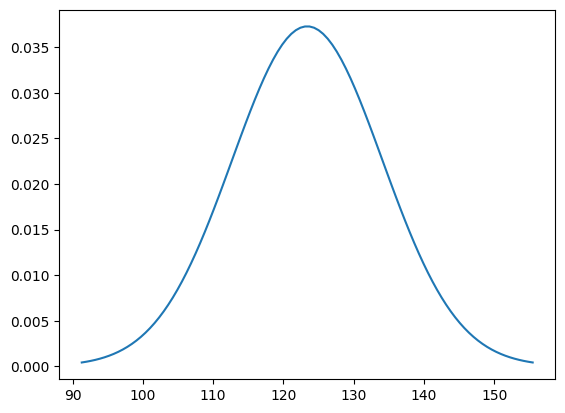

In [11]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Plot bell curve of predicted scores
x = np.linspace(mean[0] - 3*std[0], mean[0] + 3*std[0], 100)
plt.plot(x, stats.norm.pdf(x, mean[0], std[0]))
plt.show()